# DSPL and PDSPL Cosmology Forecast

In [1]:
# import standard python modules
import numpy as np
import corner
import copy
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from astropy.table import Table
from multiprocessing import Pool, cpu_count

%matplotlib inline

# import lenstronomy and hierArc modules
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

import emcee
from chainconsumer import Chain
from chainconsumer import ChainConsumer
from chainconsumer import PlotConfig
from chainconsumer import ChainConfig
from chainconsumer.plotting import plot_contour

from hierarc.Likelihood.LensLikelihood.double_source_plane import (
    beta_double_source_plane, beta2theta_e_ratio
)

# imports directly from the project repository
# from plot_util import *

# matplotlib configs
from pylab import rc

rc("axes", linewidth=2)
rc("xtick", labelsize=15)
rc("ytick", labelsize=15)

## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [2]:
# define a cosmology
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# define hierarchical model

kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "NONE",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}

gamma_pl_mean = 2.05
gamma_pl_sigma = 0.05

lambda_mst_mean = 1
lambda_mst_sigma = 0.05

def draw_lens_from_given_zs(z_lens, z1, z2, 
                            lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma, 
                            sigma_beta, 
                            down_sampling=1, with_noise=False):
    """
    draw the likelihood object of a double source plane lens

    :param z_lens: redshift of the lens
    :param z1: redshift of the first source plane
    :param z2: redshift of the second source plane
    :param lambda_mst_mean: mean value of the mass-sheet transformation parameter
    :param lambda_mst_sigma: standard deviation of the mass-sheet transformation parameter
    :param gamma_pl_mean: mean value of the power-law slope of the lensing potential
    :param gamma_pl_sigma: standard deviation of the power-law slope of the lensing potential
    :param sigma_beta: relative precision on Einstein radius, used to compute the noise on the measured beta
    
    :param down_sampling: downsampling factor, noise will be reduced by sqrt(down_sampling)
    """
    beta = beta_double_source_plane(z_lens, z1, z2, cosmo_true)
    
    beta_e_list = []
    beta_e_mean = beta2theta_e_ratio(beta_dsp=beta, gamma_pl=gamma_pl_mean, lambda_mst=lambda_mst_mean)
    for i in range(100):
        lambda_mst = np.random.normal(lambda_mst_mean, lambda_mst_sigma)
        gamma_pl = np.random.normal(gamma_pl_mean, gamma_pl_sigma)
        beta_e_ = beta2theta_e_ratio(beta_dsp=beta, gamma_pl=gamma_pl, lambda_mst=lambda_mst)
        beta_e_list.append(beta_e_)
    beta_e_list = np.array(beta_e_list)
    beta_e_mean_ = np.mean(beta_e_list)
    beta_e_sigma = np.sqrt(np.std(beta_e_list)**2 + (sigma_beta * beta_e_mean)**2) / np.sqrt(down_sampling)
    if with_noise:
        beta_measured = beta_e_mean + np.random.normal(loc=0, scale=beta_e_sigma)
    else:
        beta_measured = beta_e_mean

    kwargs_likelihood = {
        "z_lens": z_lens,
        "z_source": z1,
        "z_source2": z2,
        "beta_dspl": beta_measured,
        "sigma_beta_dspl": beta_e_sigma,
        "likelihood_type": "DSPL",
    }
    return kwargs_likelihood

## Settings for population of DSPL

In [3]:
# =====================================
# Settings for population of DSPL
# =====================================

# number of double source plane lenses
num_dspl = 100

sigma_beta_dspl = 0.1  # relative precision on Einstein radius ratio

kwargs_dspl_list = []

for i in range(num_dspl):
    z_lens = np.random.uniform(low=0.1, high=1)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.normal(2, 1)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.normal(2, 1)
    if z1 > z2:
        z1, z2 = z2, z1
    kwargs_dspl_list.append(draw_lens_from_given_zs(z_lens, z1, z2,
                                                     lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                                                     sigma_beta=sigma_beta_dspl,
                                                     with_noise=True,))

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))


In [4]:
# =====================================
# Settings for population of DSPL@
# =====================================

# number of double source plane lenses
num_dspl = 1000

sigma_beta_dspl = 0.1  # relative precision on Einstein radius ratio

kwargs_dspl_list2 = []

for i in range(num_dspl):
    z_lens = np.random.uniform(low=0.1, high=1)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.normal(2, 1)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.normal(2, 1)
    if z1 > z2:
        z1, z2 = z2, z1
    kwargs_dspl_list2.append(draw_lens_from_given_zs(z_lens, z1, z2,
                                                     lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                                                     sigma_beta=sigma_beta_dspl,
                                                     with_noise=True,))

## hierArc sampling settings

In [5]:
kwargs_mean_start = {"kwargs_cosmo": {"h0": 70, "om": 0.3, "w0": -1, "wa": 0},
                    "kwargs_lens": {"lambda_mst": lambda_mst_mean, "lambda_mst_sigma": lambda_mst_sigma,
                                    "gamma_pl_mean": gamma_pl_mean, "gamma_pl_sigma": gamma_pl_sigma}}

kwargs_sigma_start = {"kwargs_cosmo": {"h0": 10, "om": 0.05, "w0": 0.2, "wa": 0.1},
                     "kwargs_lens": {"lambda_mst": 0.1, "lambda_mst_sigma": 0.01,
                                     "gamma_pl_mean": 0.1, "gamma_pl_sigma": 0.01}}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w0": -2, "wa": -3},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w0": 0, "wa": 3},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},
    
    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5},
    "kwargs_fixed_lens": {"gamma_pl_sigma": gamma_pl_sigma, "lambda_mst_sigma": lambda_mst_sigma}
}


kwargs_sampler = {"custom_prior": None,
                  "interpolate_cosmo": False,
                  "num_redshift_interp": 100,
                  "cosmo_fixed": None,
                 }

In [6]:
mcmc_sampler_dspl = MCMCSampler(kwargs_dspl_list, cosmology=cosmology,
                           kwargs_model=kwargs_model, kwargs_bounds=kwargs_bounds,
                          **kwargs_sampler)

mcmc_sampler_dspl2 = MCMCSampler(kwargs_dspl_list2, cosmology=cosmology,
                           kwargs_model=kwargs_model, kwargs_bounds=kwargs_bounds,
                          **kwargs_sampler)

In [7]:
# sampling settings
n_walkers = 200
n_run = 1000
n_burn = 100

kwargs_emcee = {"n_walkers": n_walkers, "n_run": n_run, "n_burn": n_burn, 
                "continue_from_backend": False,
                "kwargs_mean_start": kwargs_mean_start, "kwargs_sigma_start": kwargs_sigma_start,}

    

with Pool(processes=cpu_count()) as pool:
    print(f"Starting MCMC run [DSPL]: {n_walkers} walkers, {n_run} steps, {cpu_count()} cores...")
    kwargs_emcee_dspl = copy.deepcopy(kwargs_emcee)
    emcee_sampler_dspl = mcmc_sampler_dspl.get_emcee_sampler(**kwargs_emcee_dspl,
                                                             pool=pool)   
    #mcmc_samples_dspl, log_prob = mcmc_sampler_dspl.mcmc_emcee(backend=backend_dspl, **kwargs_emcee_dspl)

with Pool(processes=cpu_count()) as pool:
    print(f"Starting MCMC run [DSPL2]: {n_walkers} walkers, {n_run} steps, {cpu_count()} cores...")
    kwargs_emcee_dspl2 = copy.deepcopy(kwargs_emcee)
    emcee_sampler_dspl2 = mcmc_sampler_dspl2.get_emcee_sampler(**kwargs_emcee_dspl2,
                                                             pool=pool)   
    #mcmc_samples_dspl2, log_prob = mcmc_sampler_dspl2.mcmc_emcee(backend=backend_dspl2, **kwargs_emcee_dspl2)


Starting MCMC run [DSPL]: 200 walkers, 1000 steps, 11 cores...


/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  retu

Starting MCMC run [DSPL2]: 200 walkers, 1000 steps, 11 cores...


/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  retu

In [ ]:
# external priors

sigma_lambda_prior = 0.01
sigma_gamma_prior = 0.01
sigma_omega_m_prior = 0.05


#flat_samples = sampler.get_chain(discard=n_burn, thin=1, flat=True)

def add_prior_to_chain(chain):
    chain_weights = copy.deepcopy(chain)
    lambda_int = chain.samples[r"$\overline{\lambda}_{\rm int}$"]
    om = chain.samples[r"$\Omega_{\rm m}$"]
    gamma_pl = chain.samples['$\\gamma_{\\rm pl, global}$']
    weights_om = -(om - om_true)**2 / (2*sigma_omega_m_prior**2)
    weights_lambda = -(lambda_int - lambda_mst_mean)**2 / (2*sigma_lambda_prior**2)
    weights_gamma = -(gamma_pl - gamma_pl_mean)**2 / (2*sigma_gamma_prior**2)
    weights = np.exp(weights_gamma + weights_lambda + weights_om)
    weights[weights < 10**(-10)] = 10**(-10)
    chain_weights.samples["weight"] = weights
    chain_weights.name = chain.name+" + deflector prior"
    return chain_weights

In [8]:
n_discard_dspl = int(5000 / n_walkers)

dspl_param_names = mcmc_sampler_dspl.param_names(latex_style=True)
print(dspl_param_names)

kde_kernel=0.5

dspl_chain = Chain.from_emcee(
    emcee_sampler_dspl,
    dspl_param_names,
    f"DSPL [87 lenses; {sigma_beta_dspl*100 :.2f}%]",
    discard=n_discard_dspl,
    thin=1,
    kde=kde_kernel,
)

dspl_chain2 = Chain.from_emcee(
    emcee_sampler_dspl2,
    dspl_param_names,
    f"DSPL2 [1000 lenses; {sigma_beta_dspl*100 :.2f}%]",
    discard=n_discard_dspl,
    thin=1,
    kde=kde_kernel,
)

dspl_chain_prior = add_prior_to_chain(dspl_chain)
dspl_chain2_prior = add_prior_to_chain(dspl_chain2)

['$\\Omega_{\\rm m}$', '$w_0$', '$w_{\\rm a}$', '$\\overline{\\lambda}_{\\rm int}$', '$\\gamma_{\\rm pl, global}$']


NameError: name 'add_prior_to_chain' is not defined

Parameter $\Omega_{\rm m}$ in chain DSPL [87 lenses; 10.00%] is not constrained
/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_15265/4289573451.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


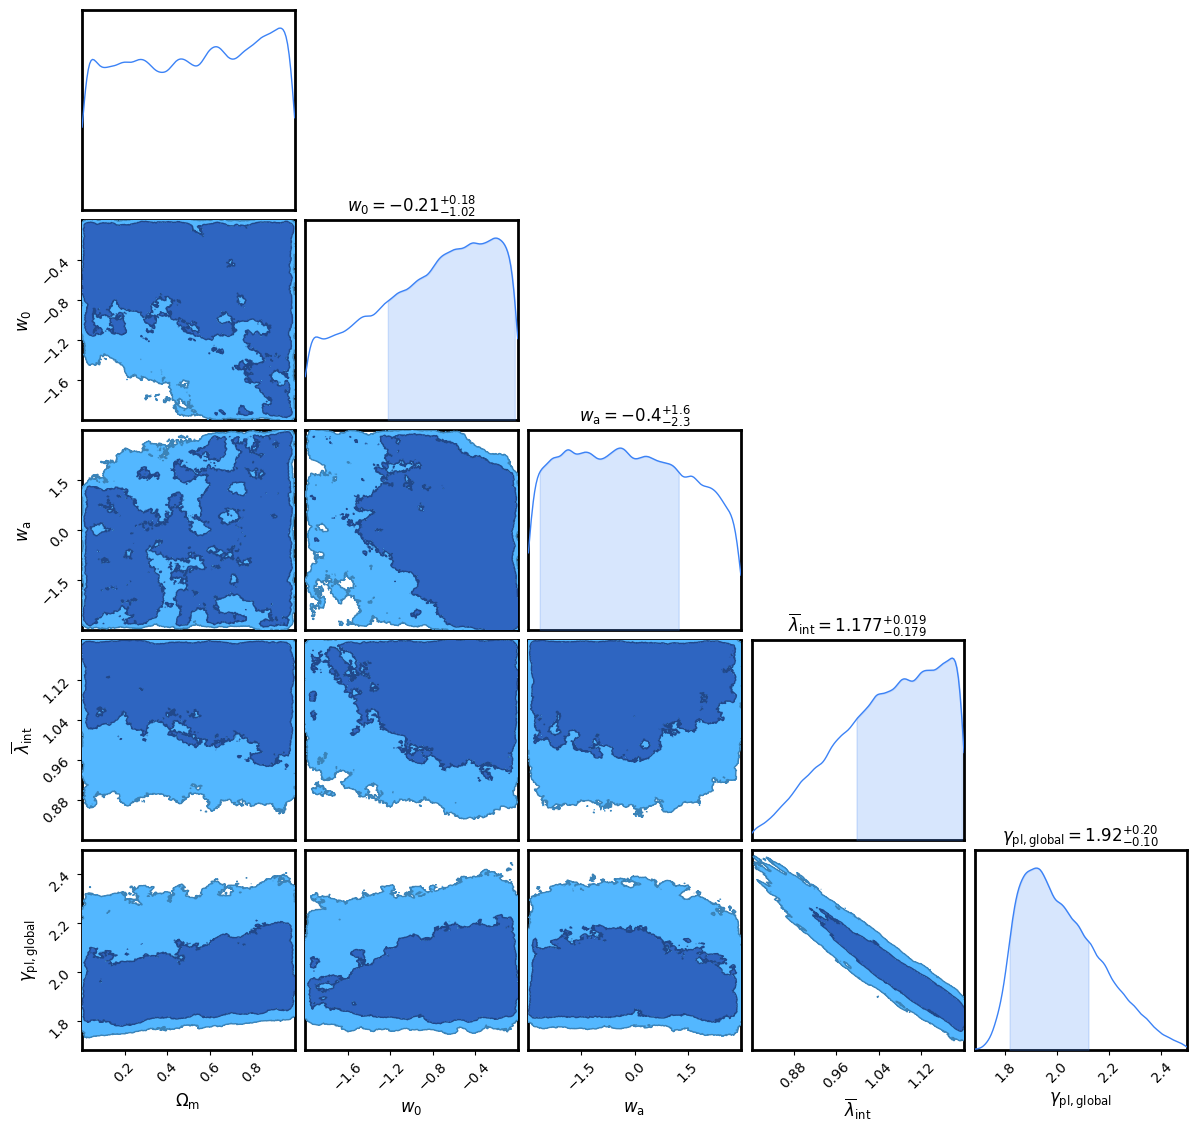

In [9]:

consumer = ChainConsumer().add_chain(dspl_chain)
#consumer.add_chain(dspl_chain_prior)

# fig = consumer.plotter.plot_walks()
# fig.show()

fig = consumer.plotter.plot()
fig.show()

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_15265/1367791031.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


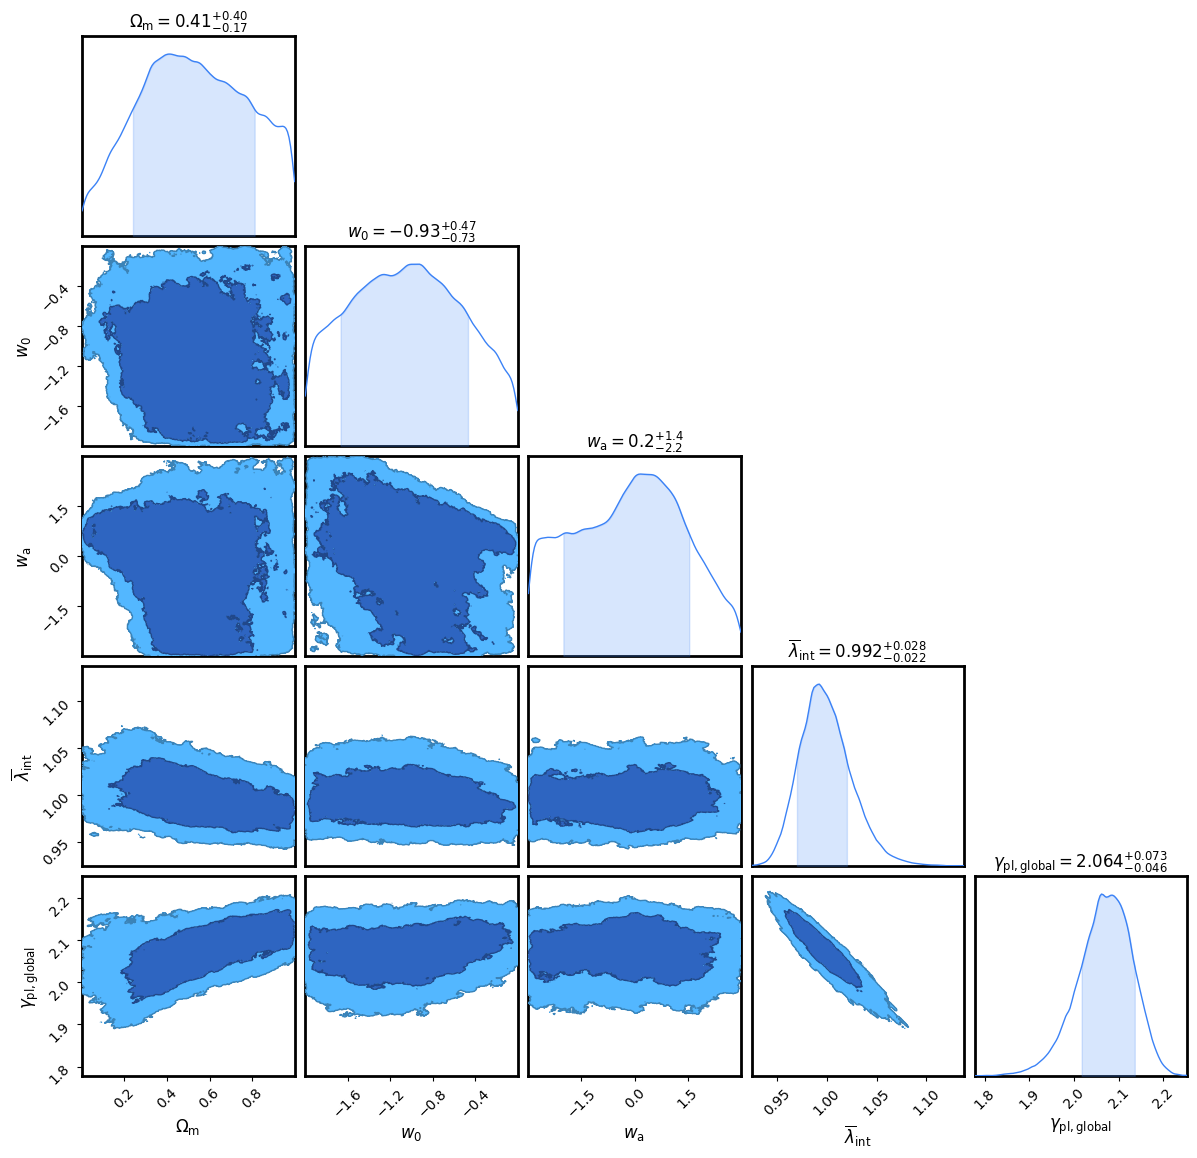

In [10]:

consumer = ChainConsumer().add_chain(dspl_chain2)
#consumer.add_chain(dspl_chain_prior)

# fig = consumer.plotter.plot_walks()
# fig.show()

fig = consumer.plotter.plot()
fig.show()

## Make combined plot

In [ ]:
save_figures = False

# set_fontscale(2.0)

# figure_width_inches = page_width_in * 2



def plot_consumer(consumer, save_figures=False, figure_name='forecast.pdf', extents=None):

    if extents is None:
        extents = {
                r"$w$": [-1.5, -0.5],
                r"$\Omega_{\rm m}$": [0.2, 0.4],
                r"$\overline{\lambda}_{\rm int}$": [0.9, 1.1],
                r"$\overline{\gamma}_{\rm pl}$": [2, 2.1],
            }
    consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

    # consumer.set_override(ChainConfig(kde=2.0))
    # consumer.set_override(
    #     ChainConfig(
    #         shade_alpha=0.5,
    #         # sigmas=np.linspace(0, 1, 10).tolist(),
    #         shade_gradient=2.0,
    #         # plot_cloud=True,
    #     )
    # )

    fig = consumer.plotter.plot(
        columns=[r"$\Omega_{\rm m}$", r"$w$", r"$\overline{\lambda}_{\rm int}$", r"$\overline{\gamma}_{\rm pl}$"],
        # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
    )

    #fig.axes[0, 0].get_legend().set_zorder(100)
    # fig.axes[0].get_legend().set_frame_on(True)
    #fig.axes[0, 0].get_legend().set_alpha(0.1)

    if save_figures:
        fig.savefig('../figures/'+figure_name, bbox_inches="tight")

    return fig

Parameter $w_0$ in chain PDSPL [30 deg²; 14.23%] is not constrained
/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_4139/954550837.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


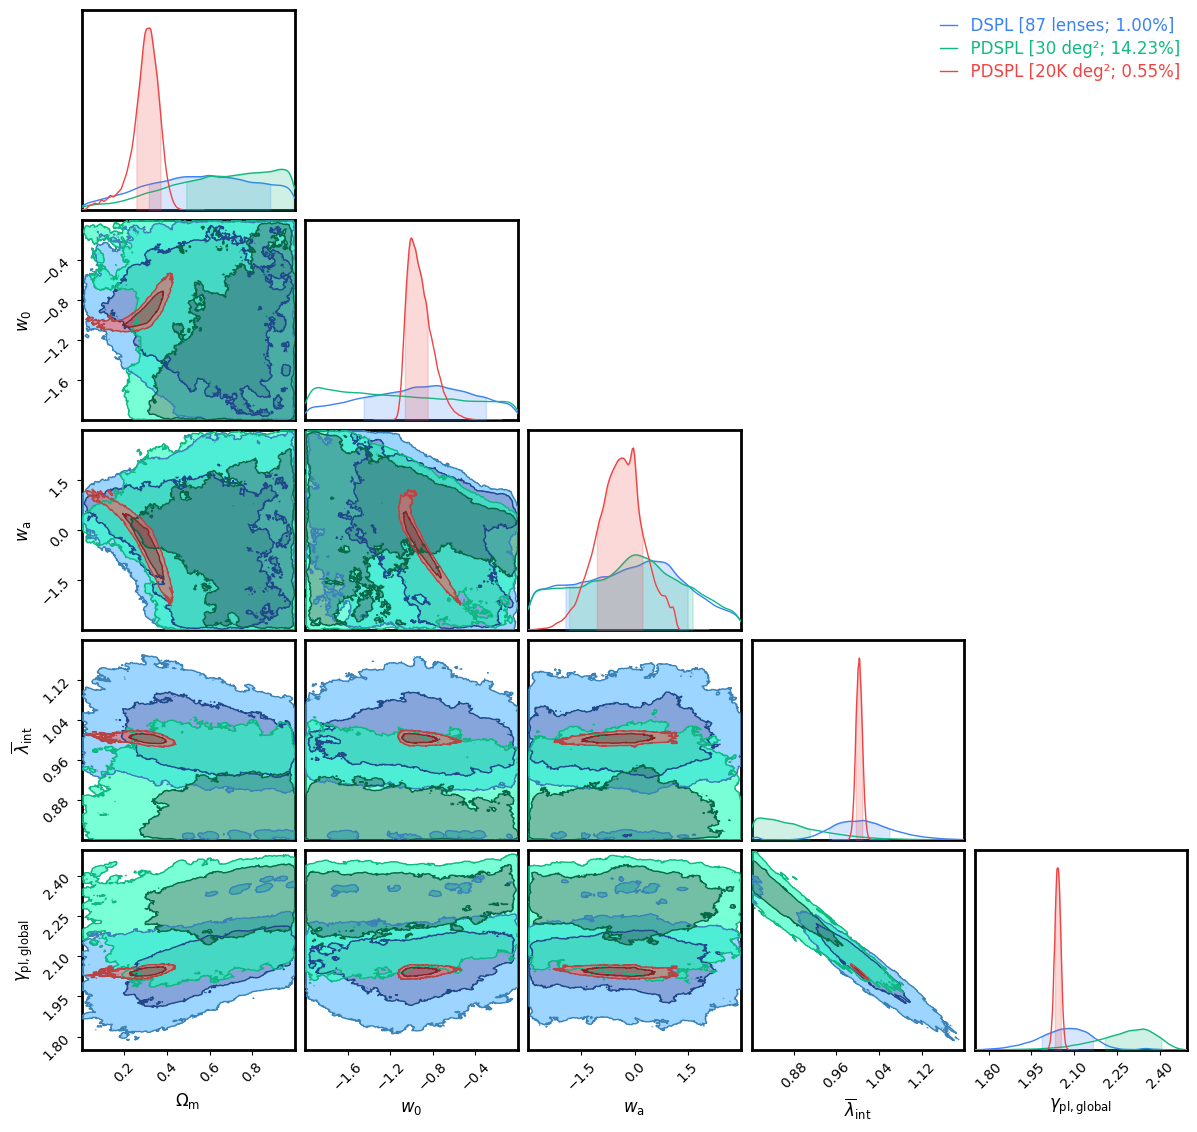

In [44]:
consumer = ChainConsumer()

consumer.add_chain(dspl_chain)
consumer.add_chain(pseudo_chain)
consumer.add_chain(pseudo_chain_ds)

fig = consumer.plotter.plot()

fig.show()


fig.savefig('../figures/forecast.pdf', bbox_inches="tight")


## Forecast Plots with Deflector Priors

Parameter $\overline{\gamma}_{\rm pl}$ in chain DSPL + deflector prior is not constrained


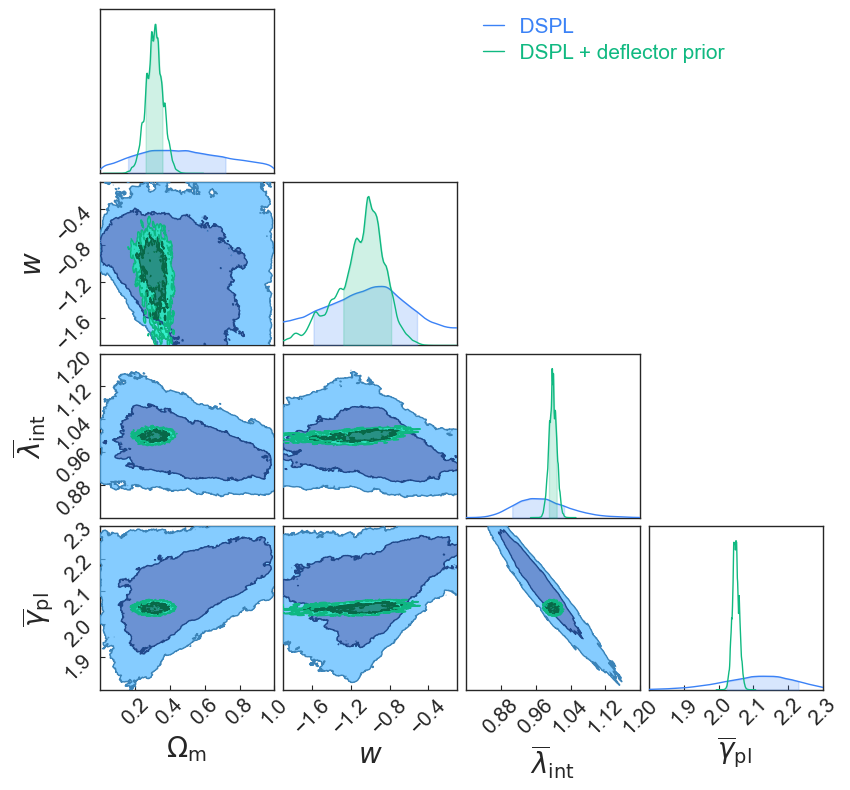

In [ ]:
consumer = ChainConsumer()

consumer.add_chain(dspl_chain)
consumer.add_chain(dspl_chain_prior)
#consumer.add_chain(pseudo_chain_prior)
#consumer.add_chain(joint_chain_prior)

extents_dspl = {
                r"$w$": [-1.9, -0.1],
                r"$\Omega_{\rm m}$": [0., 1],
                r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
                r"$\overline{\gamma}_{\rm pl}$": [1.8, 2.3],
            }

plot_consumer(consumer, save_figures=False, figure_name='dspl_forecast.pdf', extents=extents_dspl)

Parameter $\overline{\gamma}_{\rm pl}$ in chain DSPL + deflector prior is not constrained


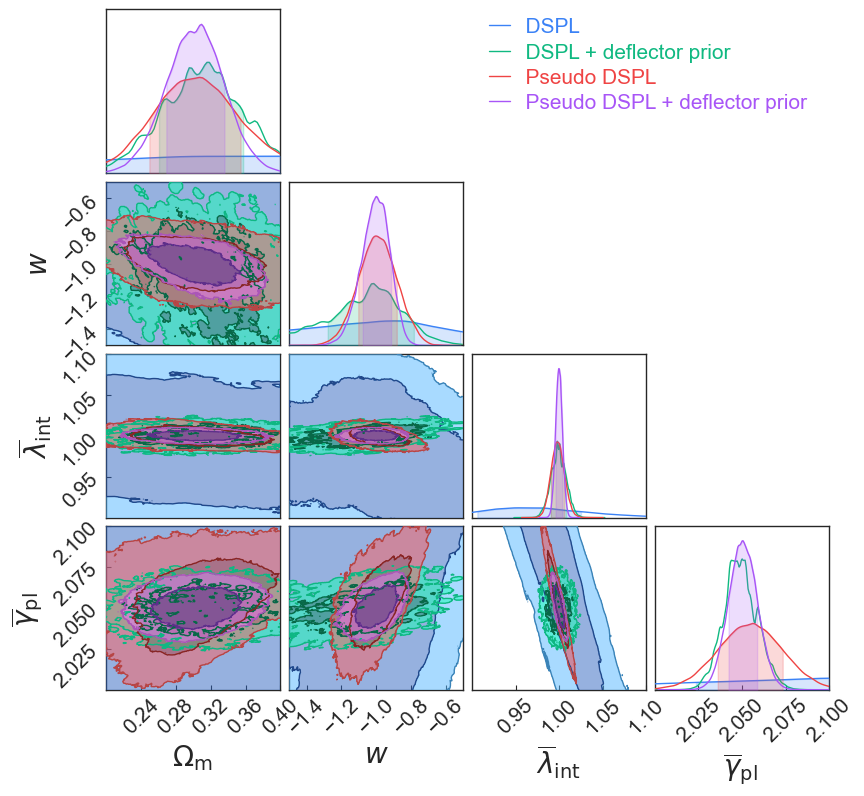

In [ ]:

consumer = ChainConsumer()

consumer.add_chain(dspl_chain)
consumer.add_chain(dspl_chain_prior)
consumer.add_chain(pseudo_chain)
consumer.add_chain(pseudo_chain_prior)

plot_consumer(consumer, save_figures=False, figure_name='combined_forecast.pdf')